In [1]:
include("IsingCore.jl")
using .IsingCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(IsingCore))

[:IsingCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [2]:
N = 20
β_min = 1/10
β_max = 1
M = 20
η = 0.001
mcSteps=10^3
eqSteps=10^2
# target = 0.23
epochs = 300
batch_size = 10
@info """
Hyperparameters of Ising model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
exchange_prob_means, _ = IsingCore.calc_acceptance_and_rtt(N, init_β_ladder)

println(init_β_ladder)
println(exchange_prob_means)

[0.1, 0.1128837891684689, 0.12742749857031335, 0.14384498882876626, 0.16237767391887217, 0.18329807108324359, 0.20691380811147894, 0.2335721469090122, 0.2636650898730358, 0.2976351441631318, 0.33598182862837817, 0.3792690190732249, 0.4281332398719394, 0.4832930238571753, 0.5455594781168519, 0.6158482110660264, 0.6951927961775605, 0.7847599703514612, 0.8858667904100826, 1.0]
[0.7924316688205285, 0.7682184668439073, 0.7374717136351303, 0.691582606468028, 0.657395544300555, 0.6073286827014691, 0.5532804907730418, 0.4897046921097459, 0.4068226330883253, 0.31378904570674043, 0.2188857510944383, 0.07611002664673482, 0.049268939337627694, 0.17281767573773266, 0.30635888229883007, 0.4374060246869958, 0.5703700441415938, 0.6997956219079999, 0.8243310790828855]


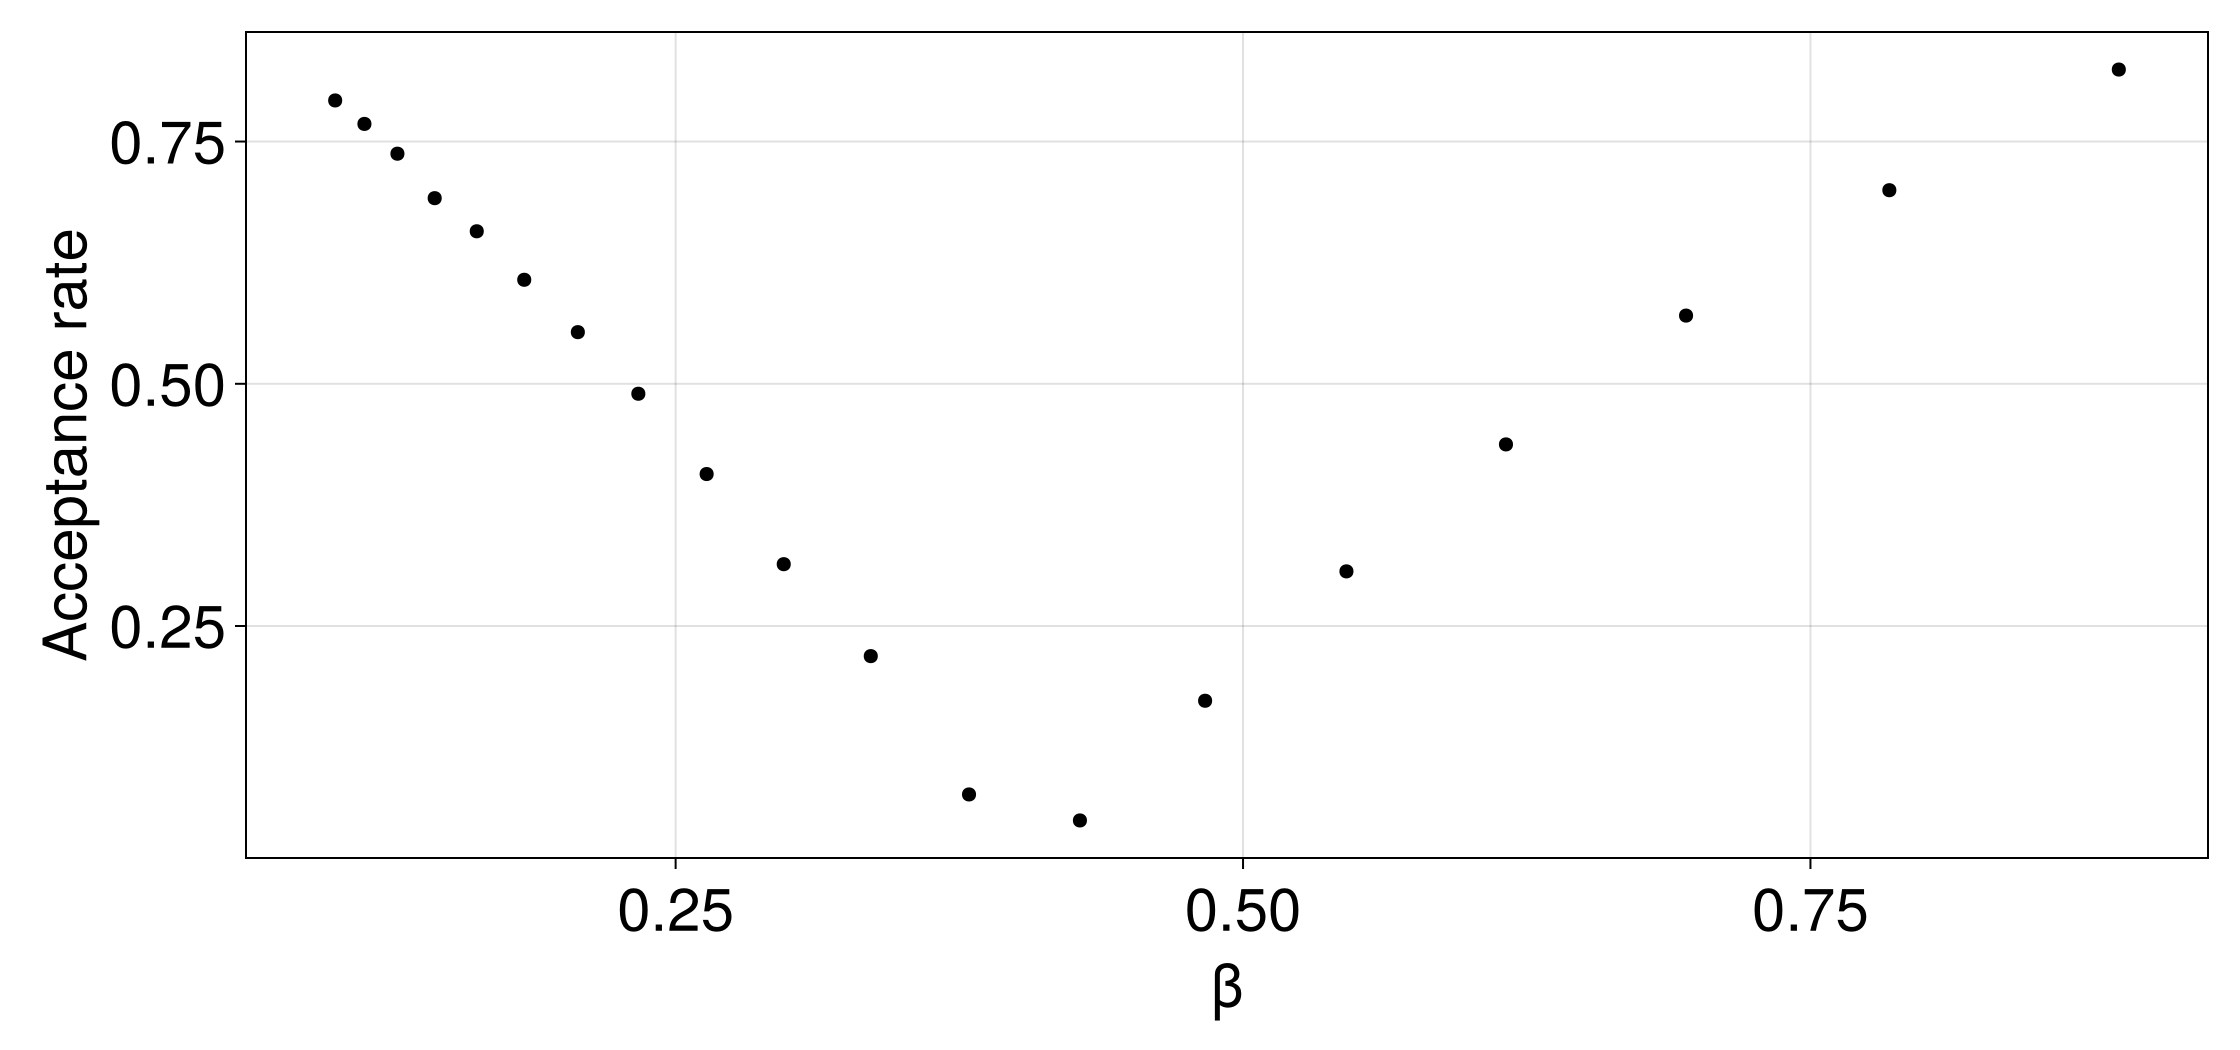

CairoMakie.Screen{IMAGE}


In [4]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_ladder[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [5]:
β_ladder = deepcopy(init_β_ladder)
β_ladder_trace = [β_ladder]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_ladder)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = IsingCore.score_method(
            N, 
            β_ladder;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    # grad_mean[end] = 0.0
    setup, β_ladder = Optimisers.update(setup, β_ladder, grad_mean)

    push!(β_ladder_trace, deepcopy(β_ladder))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 0:16:43


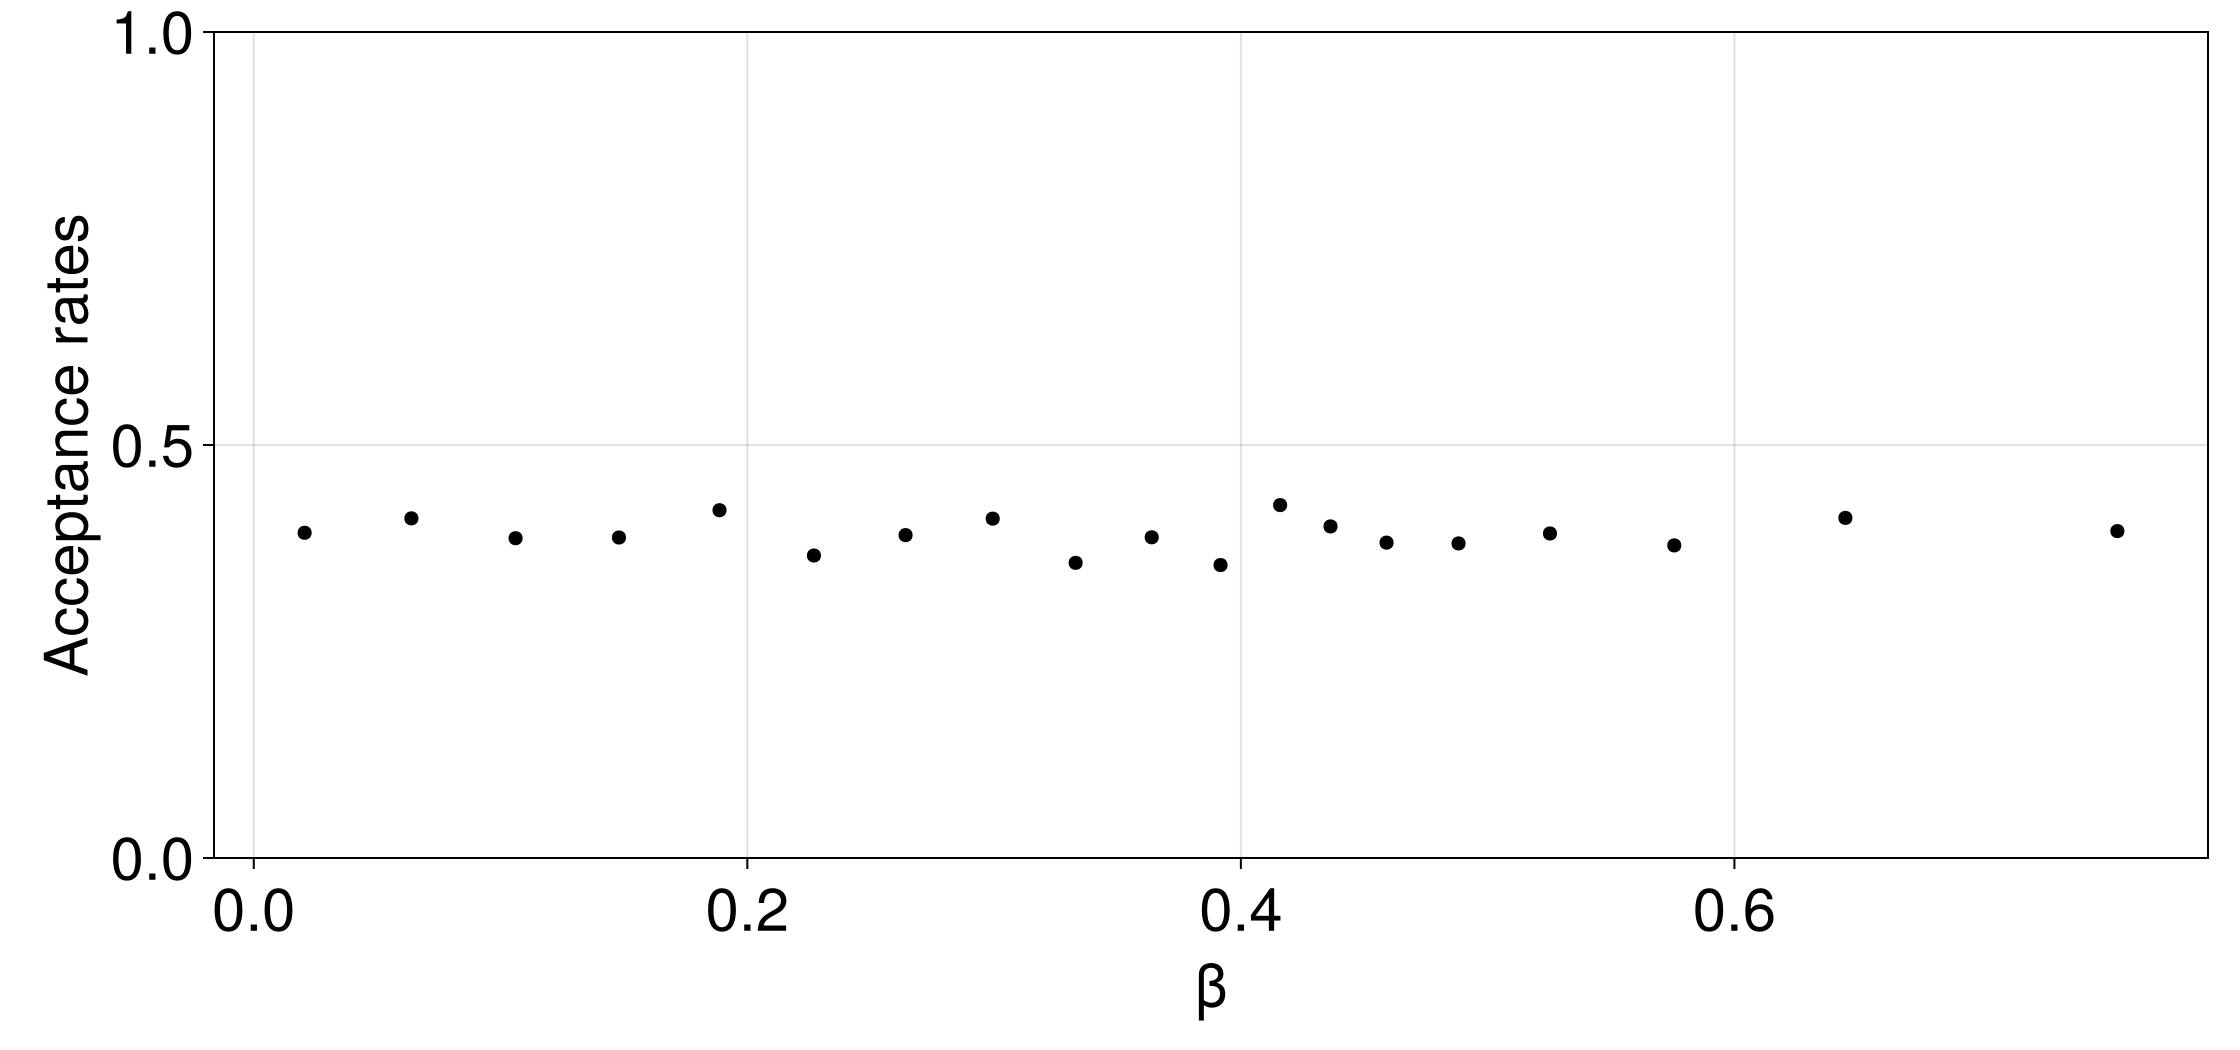

CairoMakie.Screen{IMAGE}


In [7]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_ladder_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

In [8]:
dir = "../../plots/Ising_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Ising_model/L=20/M=20"

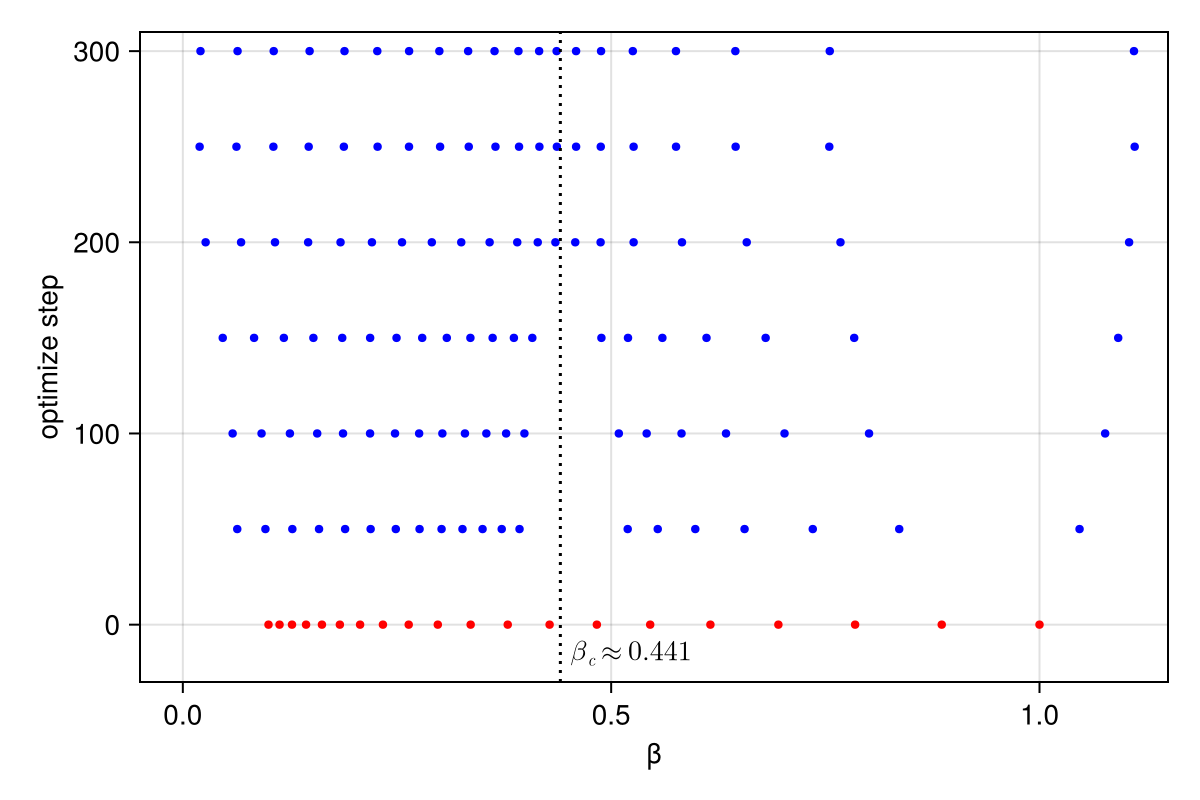

In [9]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
xlims!(ax, -0.05, 1.15)
ylims!(ax, -30, epochs+10)

plot_interval = 50
for (i, β_ladder) in enumerate(β_ladder_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_ladder
        y_values = fill(step, length(β_values))
        marker_color = (step == 0) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
β_c = log(1 + sqrt(2)) / 2
vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
text!(
    ax,
    L"\beta_c \approx %$(round(β_c, digits=3))", 
    position = (β_c, -15), 
    align = (:left, :center), 
    offset = (5, 0)
)
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

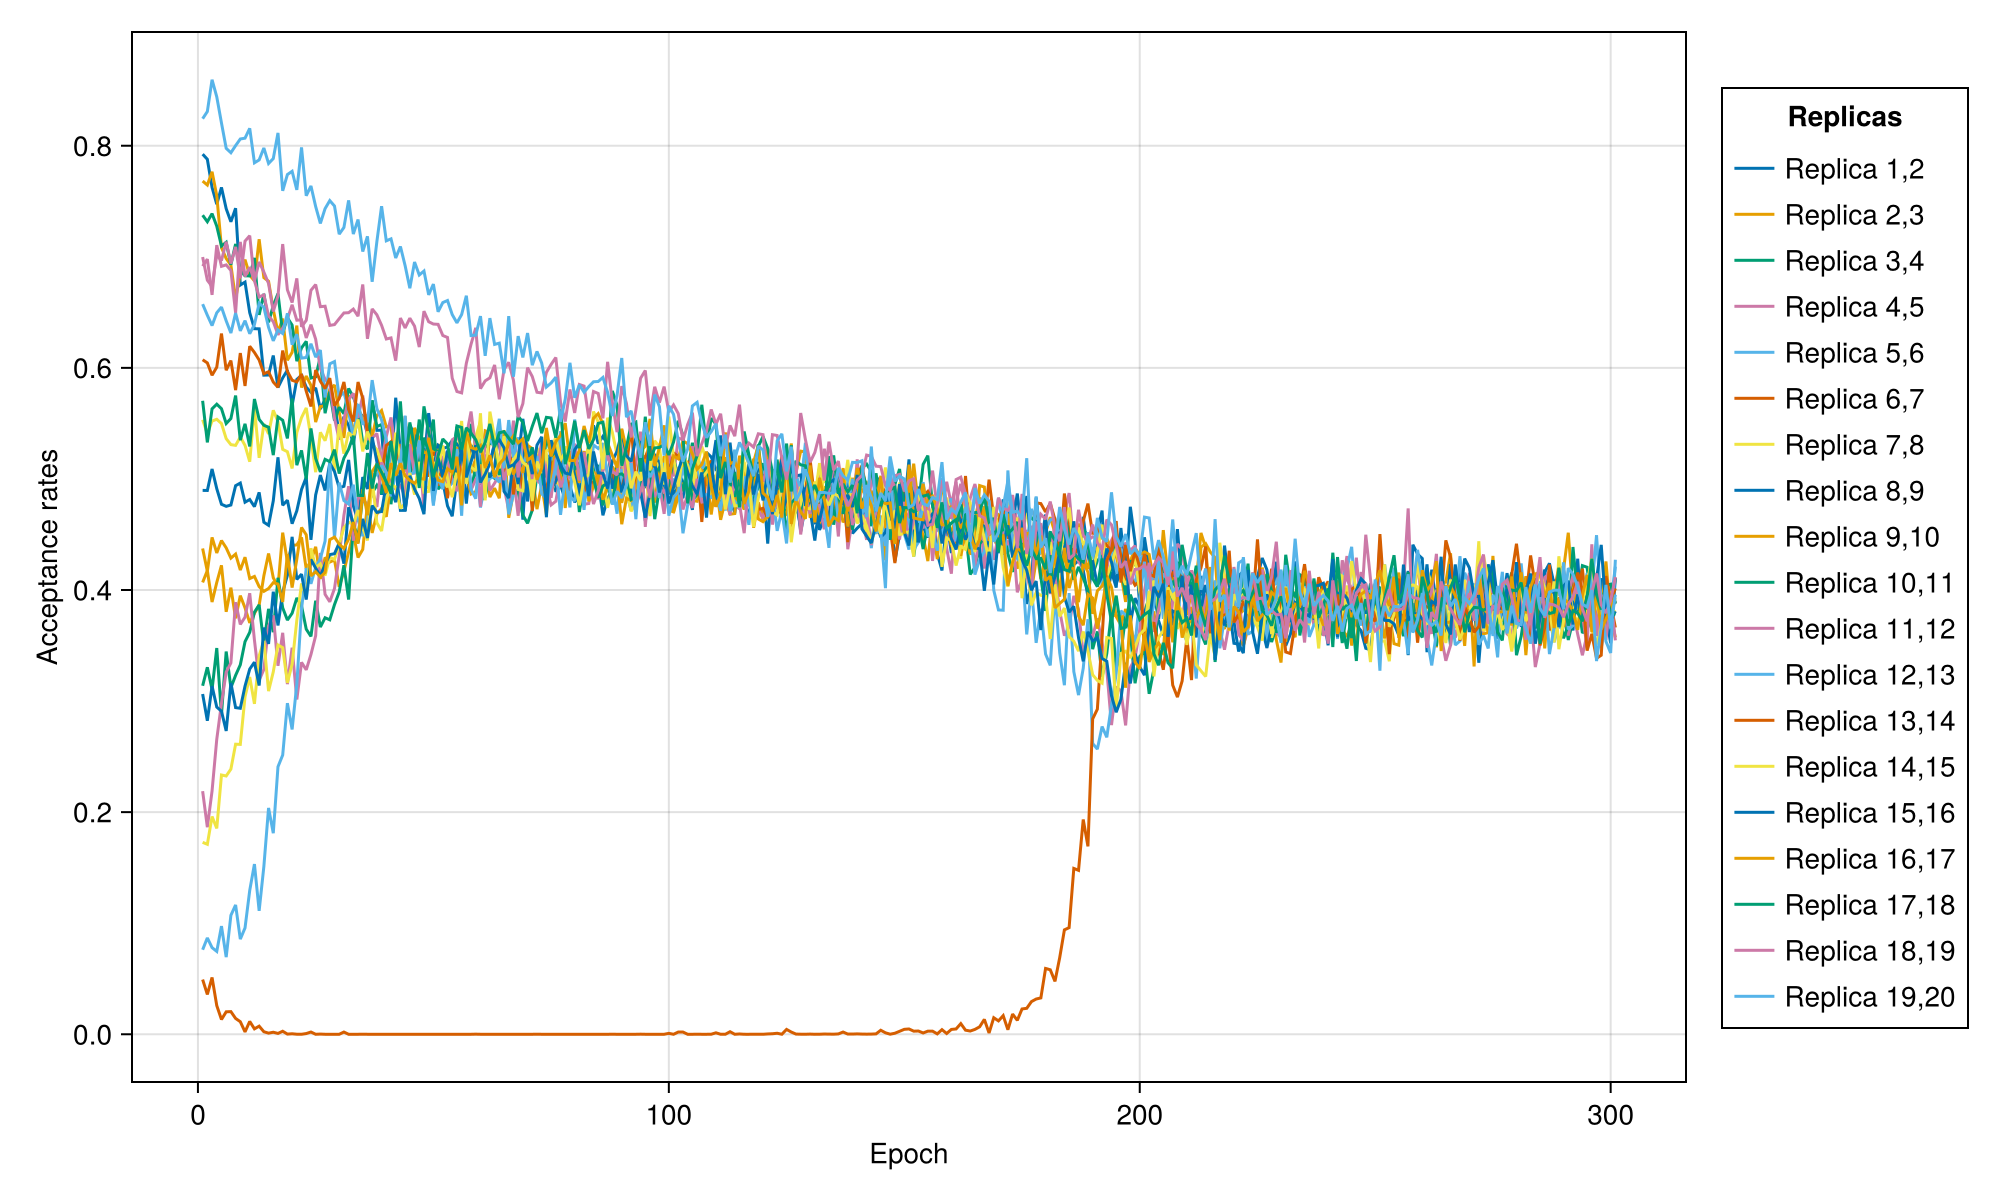

In [10]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

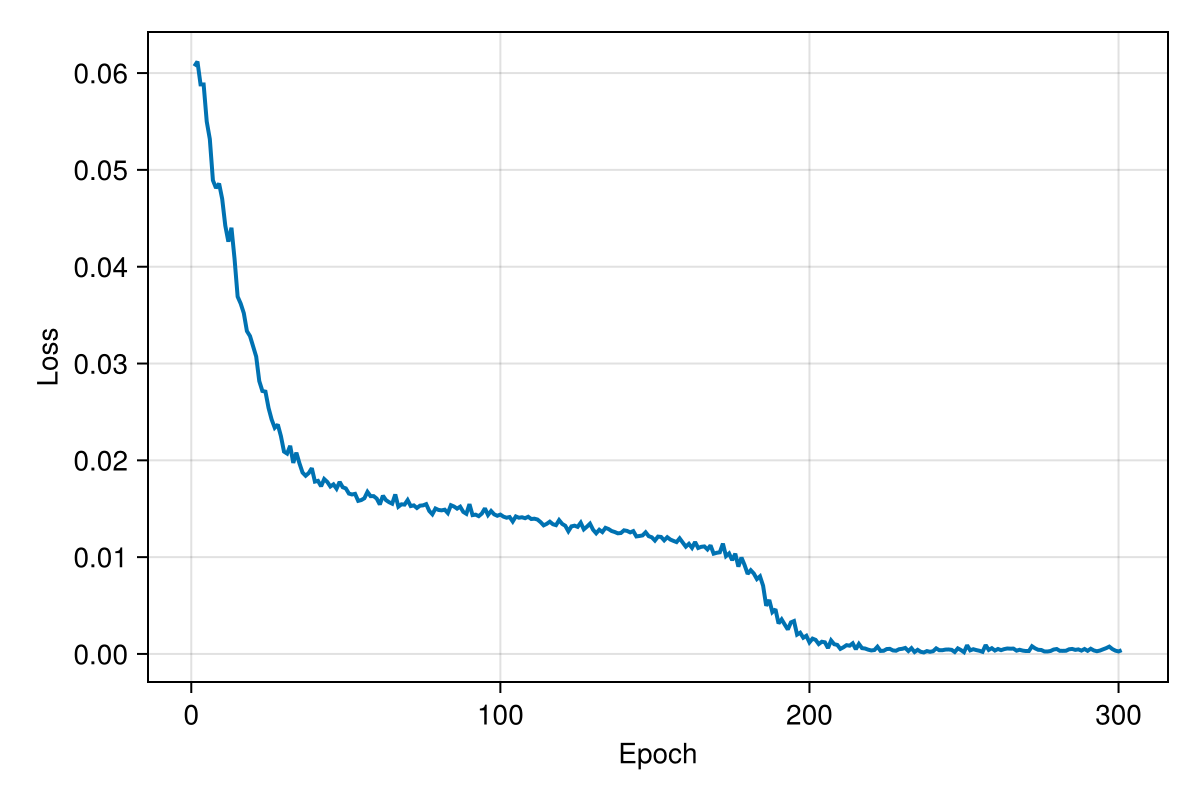

In [11]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [12]:
println(β_ladder_trace[end])

[0.020615714837037016, 0.06388475620295729, 0.10609376436527308, 0.14798741811786267, 0.18873113048875065, 0.22699198456125427, 0.2641270230676485, 0.29943887237875827, 0.3330433375234771, 0.3638706503389226, 0.39176278979964224, 0.4159134884751802, 0.4363259632289058, 0.45903451959631836, 0.48820478772312065, 0.5252584680730991, 0.575617591327538, 0.644967991157092, 0.7551749693265066, 1.110282074113982]
